In [2]:
# !pip install pytorch-lightning
# !pip install transformers
# !pip install vncorenlp

In [2]:
# from google.colab import drive
# drive.mount("/content/drive")

In [3]:
!nvidia-smi

Mon Apr 18 09:49:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:5E:00.0 Off |                  N/A |
|  0%   25C    P8     1W / 250W |   4875MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:86:00.0 Off |                  N/A |
|  0%   

In [97]:
# !kill -9 893242

In [5]:
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
import zipfile
from PIL import Image
import matplotlib.pyplot as plt
import re
import pytorch_lightning as pl
from torchvision import transforms as T
from sklearn.model_selection import train_test_split

train_ratio = 0.8

/home/nghiatl/anaconda3/envs/AI_DA/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [99]:
import random

# SEED_VALUE = random.randint(0,100)
SEED_VALUE = 25
# print(SEED_VALUE)
random.seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)
torch.cuda.manual_seed(SEED_VALUE)
np.random.seed(SEED_VALUE)

In [10]:
# %cd /content/drive/MyDrive/Colab Notebooks/Multimodal

In [11]:
!ls
data_zip_file = './local1_folder.zip'
# data_zip_file2 = './local1_folder_temp.zip'

csv_file2 = './OUTPUT/Comment_22.csv'
csv_file3 = './OUTPUT/Comment_23.csv'
csv_file4 = './OUTPUT/Comment_24.csv'
csv_file5 = './OUTPUT/Comment_25.csv'

csv_file = './OUTPUT/Comment.csv'

CNN.ipynb
Inception-Copy1.ipynb
Inception.ipynb
Inception-VotingMultimodal.ipynb
local1_folder_temp.zip
local1_folder.zip
Multimodal_newmodel.ipynb
Multimodal_newmodel-weight.ipynb
my_checkpoint_incept_seed0_bt8_fc_2048_re512_re128_1e-3.pth.tar
my_checkpoint_incept_seed7_bt8_fc_2048_re512_re128_1e-3_f1.pth.tar
my_checkpoint_incept_seed7_bt8_fc_2048_re512_re128_1e-3.pth.tar
my_checkpoint_incept_voting_f1.pth.tar
my_checkpoint_incept_voting.pth.tar
my_checkpoint_multi_bt_8_mrTrong_f1.pth.tar
my_checkpoint_multi_bt_8_mrTrong_f1_seed7.pth.tar
my_checkpoint_multi_bt_8_mrTrong.pth.tar
my_checkpoint_multi_bt_8_mrTrong_seed7.pth.tar
my_checkpoint_multivoting_20_label01_freeze_adam_normalize_img_f1_fc2048512.pth.tar
my_checkpoint_multivoting_20_label01_freeze_adam_normalize_img_f1_nodrop.pth.tar
my_checkpoint_multivoting_20_label01_freeze_adam_normalize_img_f1.pth.tar
my_checkpoint_multivoting_20_label01_freeze_adam_normalize_img_fc2048512.pth.tar
my_checkpoint_multivoting_20_label01_freeze_ada

# Data preprocessing

## Image data

In [12]:
data_zip = zipfile.ZipFile(data_zip_file)

In [13]:
# data_zip2 = zipfile.ZipFile(data_zip_file2)

In [14]:
len(data_zip.namelist())

58766

In [15]:
'local1_folder-1/foody-fukunohana-hanoi-japanese-retstaurant-970-637197316556573205.jpg' in data_zip.namelist()

True

local1_folder-1/foody-fukunohana-hanoi-japanese-retstaurant-970-637197316556573205.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=800x734 at 0x7FE36C756830>
(734, 800, 3)


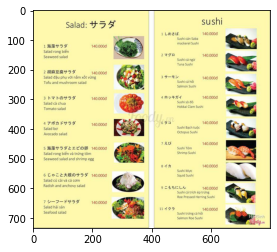

In [16]:
img_path = data_zip.namelist()[1]
print(img_path)
img = Image.open(data_zip.open(img_path))
print(img)
print(np.asarray(img).shape)
plt.imshow(img)

In [17]:
# ### Scale image to [0,1]
# trans = T.ToTensor()
# trans(img).shape

## CSV data

In [18]:
data_df1 = pd.read_csv(csv_file)
data_df2 = pd.read_csv(csv_file2)
data_df3 = pd.read_csv(csv_file3)
data_df4 = pd.read_csv(csv_file4)
data_df5 = pd.read_csv(csv_file5)


data_df1[['Comment', 'Rating']].head()

,Comment,Rating
0,Đặt dồi sụn của quán vì đọc comment thấy hấp d...,5.8
1,"Dồi khá ngon, mua về còn nóng mở ra thơm phức,...",9.0
2,"Đặt xuất mỳ trộn thập cẩm, khá đầy đủ và đầy đ...",9.4
3,Không hiểu sao quán này được 7.9 luôn. Đặt bán...,4.6
4,"Dồi sụn bé tẹo, giá quá cao so với các quán kh...",1.0


In [19]:
data_df4.shape

(3093, 11)

In [20]:
data_df = pd.concat([data_df1,data_df2,data_df3,data_df4, data_df5], ignore_index = True)

In [21]:
data_df.shape

(14174, 11)

In [22]:
data_df = data_df.dropna()
data_df = data_df.reset_index(drop=True)

In [23]:
data_df.isnull().sum()

RevId                   0
UserId                  0
ResId                   0
Comment                 0
image_urls              0
Food_score_cmt          0
Services_score_cmt      0
Atmosphere_score_cmt    0
Position_score_cmt      0
Price_score_cmt         0
Rating                  0
dtype: int64

In [24]:
## Add more data
data_df.rename(columns={"Rating":"score"}, inplace=True)
data_df.head()

,RevId,UserId,ResId,Comment,image_urls,Food_score_cmt,Services_score_cmt,Atmosphere_score_cmt,Position_score_cmt,Price_score_cmt,score
0,3648046,8920424,965165,Đặt dồi sụn của quán vì đọc comment thấy hấp d...,https://images.foody.vn/res/g97/965165/s800/fo...,5.0,9.0,5.0,5.0,5.0,5.8
1,3695359,18558601,965165,"Dồi khá ngon, mua về còn nóng mở ra thơm phức,...",https://images.foody.vn/res/g97/965165/s800/fo...,10.0,10.0,9.0,8.0,8.0,9.0
2,3695487,13885433,965165,"Đặt xuất mỳ trộn thập cẩm, khá đầy đủ và đầy đ...",https://images.foody.vn/res/g97/965165/s800/fo...,10.0,10.0,9.0,8.0,10.0,9.4
3,4256913,11400976,965165,Không hiểu sao quán này được 7.9 luôn. Đặt bán...,https://images.foody.vn/res/g97/965165/s800/fo...,1.0,5.0,5.0,6.0,6.0,4.6
4,4246644,525112,965165,"Dồi sụn bé tẹo, giá quá cao so với các quán kh...",https://images.foody.vn/res/g97/965165/s800/fo...,1.0,1.0,1.0,1.0,1.0,1.0


In [25]:
data_df['image_urls'][0]

'https://images.foody.vn/res/g97/965165/s800/foody-doi-sun-pate-shop-online-389-637116772226077520.jpg,https://images.foody.vn/res/g97/965165/s800/foody-doi-sun-pate-shop-online-427-637116772199356351.jpg'

In [26]:
# ## Calculate score
# data_df['score'] = data_df.apply(lambda x: (x['Food_score_cmt']+x['Services_score_cmt']+x['Atmosphere_score_cmt']+x['Position_score_cmt']+x['Price_score_cmt'])/5, axis = 1)
data_df[(data_df['score'] >= 8) & (data_df['score'] <= 8)][['Comment','score']].sort_values(by=['score'])

,Comment,score
8,Giữa cái thời tiết HN sớm trưa mưa nắng thất t...,8.0
9677,Sáng nào mình cx phải ăn phở ở đây ms chịu đc ...,8.0
9701,"Hàng xôi tấp nập người ghé ăn & mua mang đi, n...",8.0
9705,"Quán chè nhỏ nhỏ, đối diện bakery Tati. Cô chủ...",8.0
9713,❤ Vị trí : hàng này mới mở dạo gần đây. Nằm ng...,8.0
...,...,...
4892,* mùa dịch ăn gì ??🤔🤔\nĐang mùa dịch thế này c...,8.0
4907,Suất đặc biệt cơm gà + sườn ship Now,8.0
4955,Chè sầu chính hãng nè cả nhà 😻 viêm họng mà vẫ...,8.0
5034,"Nhân ngày xe bus hỏng đúng quán ding tea, mình...",8.0


In [27]:
data_df['Comment'][8]

'Giữa cái thời tiết HN sớm trưa mưa nắng thất thường, tối phần phật gió như này thì việc ngồi nhâm nhâm nhi nhi em caramen hoa quả này là 1 điều thật tuyệt - thơm thơm ngậy ngậy của caramen, vị thanh mát của các loại hoa quả: dưa hấu, xoài, thanh long, mít....được kết hợp lại với nhau rất thú vị, cốc còn rất là đầy đặn nữa chứ. Cơ mà anh chị chủ quán làm ngon quá đi, cứ bị nghiện ý, mỗi ngày sẽ nếm 1 vị: sữa chua thạch lá nếp nè, sc hoa quả, chè khoai dẻo nè.....chu choa v.v.....vân vân và mây mây...'

In [28]:
## label data
def label_comment(x):
  if x['score'] >= 8:
    return 1
  elif (x['score'] >= 6) & (x['score'] < 8):
    return 2
  else:
    return 0
data_df['label'] = data_df.apply(label_comment, axis=1)

In [29]:
data_df = data_df[data_df['label'] != 2]

1    6953
0    3023
Name: label, dtype: int64


<AxesSubplot:>

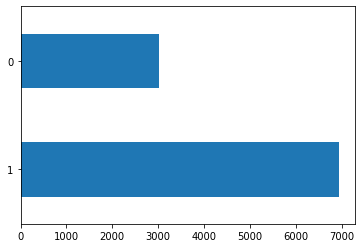

In [30]:
print(data_df['label'].value_counts())
data_df['label'].value_counts().plot(kind='barh')

In [31]:
data_df[['Comment','label', 'score']].head()

,Comment,label,score
0,Đặt dồi sụn của quán vì đọc comment thấy hấp d...,0,5.8
1,"Dồi khá ngon, mua về còn nóng mở ra thơm phức,...",1,9.0
2,"Đặt xuất mỳ trộn thập cẩm, khá đầy đủ và đầy đ...",1,9.4
3,Không hiểu sao quán này được 7.9 luôn. Đặt bán...,0,4.6
4,"Dồi sụn bé tẹo, giá quá cao so với các quán kh...",0,1.0


In [32]:
data_df = data_df.drop(['Food_score_cmt','Services_score_cmt','Atmosphere_score_cmt','Position_score_cmt','Price_score_cmt'],axis=1)
data_df.head()

,RevId,UserId,ResId,Comment,image_urls,score,label
0,3648046,8920424,965165,Đặt dồi sụn của quán vì đọc comment thấy hấp d...,https://images.foody.vn/res/g97/965165/s800/fo...,5.8,0
1,3695359,18558601,965165,"Dồi khá ngon, mua về còn nóng mở ra thơm phức,...",https://images.foody.vn/res/g97/965165/s800/fo...,9.0,1
2,3695487,13885433,965165,"Đặt xuất mỳ trộn thập cẩm, khá đầy đủ và đầy đ...",https://images.foody.vn/res/g97/965165/s800/fo...,9.4,1
3,4256913,11400976,965165,Không hiểu sao quán này được 7.9 luôn. Đặt bán...,https://images.foody.vn/res/g97/965165/s800/fo...,4.6,0
4,4246644,525112,965165,"Dồi sụn bé tẹo, giá quá cao so với các quán kh...",https://images.foody.vn/res/g97/965165/s800/fo...,1.0,0


In [33]:
def preprocess_imgpath(df):
    img_p = []
    for path in df['image_urls'].split(","):
        img_path = 'local1_folder-1/' + path.split('/')[-1]
        if img_path in data_zip.namelist():
            img_p.append(img_path)
    if len(img_p) > 0:
        return ','.join(img_p)
    return None

In [34]:
data_df['image_urls'] = data_df.apply(preprocess_imgpath, axis=1)

In [35]:
data_df.isnull().sum()

RevId         0
UserId        0
ResId         0
Comment       0
image_urls    1
score         0
label         0
dtype: int64

In [36]:
data_df = data_df.dropna()
data_df = data_df.reset_index(drop=True)
data_df.isnull().sum()

RevId         0
UserId        0
ResId         0
Comment       0
image_urls    0
score         0
label         0
dtype: int64

In [37]:
data_df.head()

,RevId,UserId,ResId,Comment,image_urls,score,label
0,3648046,8920424,965165,Đặt dồi sụn của quán vì đọc comment thấy hấp d...,local1_folder-1/foody-doi-sun-pate-shop-online...,5.8,0
1,3695359,18558601,965165,"Dồi khá ngon, mua về còn nóng mở ra thơm phức,...",local1_folder-1/foody-doi-sun-pate-shop-online...,9.0,1
2,3695487,13885433,965165,"Đặt xuất mỳ trộn thập cẩm, khá đầy đủ và đầy đ...",local1_folder-1/foody-doi-sun-pate-shop-online...,9.4,1
3,4256913,11400976,965165,Không hiểu sao quán này được 7.9 luôn. Đặt bán...,local1_folder-1/foody-doi-sun-pate-shop-online...,4.6,0
4,4246644,525112,965165,"Dồi sụn bé tẹo, giá quá cao so với các quán kh...",local1_folder-1/foody-doi-sun-pate-shop-online...,1.0,0


1    6952
0    3023
Name: label, dtype: int64


<AxesSubplot:>

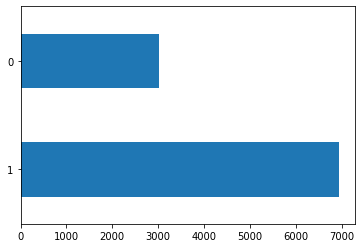

In [38]:
print(data_df['label'].value_counts())
data_df['label'].value_counts().plot(kind='barh')

In [39]:
def loaddicchar():
    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|đ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
        '|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|đ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic
 
 
dicchar = loaddicchar()
 
# Đưa toàn bộ dữ liệu qua hàm này để chuẩn hóa lại
def convert_unicode(txt):
    return re.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|đ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], txt)

In [40]:
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP("./vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m') 

uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
punc_re = '[^\w'+uniChars+']'
def preprocess_text(sen):
  ##Unicode reform
  assert isinstance(sen, str), 'Not String'
  sen = convert_unicode(sen)
  ##Remove punctuation
  sen = re.sub(punc_re,' ', sen)
  ##Remove multiple space
  sen = re.sub('\s+',' ', sen)
  ##Lower
  sen = sen.lower()
  ##Segment
  seg = rdrsegmenter.tokenize(sen)
  if len(seg) == 0:
    sen = ' '
  else: 
    sen = ' '.join(seg[0])
  return sen
# vec_pre = np.vectorize(preprocess_text)
# print(vec_pre((data_df.iloc[3,3])))
data_df['preprocess_comment'] = data_df.apply(lambda x: preprocess_text(x['Comment']), axis = 1)

In [41]:
data_df.head()

,RevId,UserId,ResId,Comment,image_urls,score,label,preprocess_comment
0,3648046,8920424,965165,Đặt dồi sụn của quán vì đọc comment thấy hấp d...,local1_folder-1/foody-doi-sun-pate-shop-online...,5.8,0,đặt dồi sụn của quán vì đọc comment thấy hấp_d...
1,3695359,18558601,965165,"Dồi khá ngon, mua về còn nóng mở ra thơm phức,...",local1_folder-1/foody-doi-sun-pate-shop-online...,9.0,1,dồi khá ngon mua về còn nóng mở ra thơm_phức s...
2,3695487,13885433,965165,"Đặt xuất mỳ trộn thập cẩm, khá đầy đủ và đầy đ...",local1_folder-1/foody-doi-sun-pate-shop-online...,9.4,1,đặt xuất mỳ trộn thập_cẩm khá đầy_đủ và đầy_đặ...
3,4256913,11400976,965165,Không hiểu sao quán này được 7.9 luôn. Đặt bán...,local1_folder-1/foody-doi-sun-pate-shop-online...,4.6,0,không hiểu sao quán này được 7 9 luôn đặt bánh...
4,4246644,525112,965165,"Dồi sụn bé tẹo, giá quá cao so với các quán kh...",local1_folder-1/foody-doi-sun-pate-shop-online...,1.0,0,dồi sụn bé tẹo giá quá cao so với các quán khá...


In [42]:
data_df[data_df['preprocess_comment']==" "].shape
# data_df.drop(data_df[data_df['preprocess_comment']==" "].index, inplace = True)

(9, 8)

In [43]:
data_df = data_df.reset_index()
data_df['preprocess_comment'][4187:4191]

4187    vị_trí ở mặt đường nhưng ở cạnh quán mì cay to...
4188    thật tuyệt_cú mèo luôn mỗi cốc hoa_quả dầm ở đ...
4189    mình đã ăn_ở địa_điểm 211 chùa láng được hơn 1...
4190    nghe mọi người khen quán này dữ lém nên hôm_na...
Name: preprocess_comment, dtype: object

In [44]:
a = data_df['preprocess_comment'].str.split()
a = a.apply(lambda x: len(x))
a[a==1]

314     1
415     1
744     1
1011    1
1077    1
1543    1
1779    1
1808    1
1888    1
2302    1
2337    1
2528    1
2836    1
2873    1
2976    1
3489    1
3643    1
4328    1
4409    1
4645    1
5242    1
5564    1
5976    1
6341    1
6487    1
6748    1
7554    1
7603    1
8684    1
8881    1
9377    1
9523    1
Name: preprocess_comment, dtype: int64

In [45]:
a

0        56
1        43
2        38
3        34
4        74
       ... 
9970     42
9971     48
9972    107
9973    185
9974     17
Name: preprocess_comment, Length: 9975, dtype: int64

In [46]:
data_df['Comment'][195]

'Sữa chua mít + trà đào ngon, caramen trong sữa chua ăn cũng ok, giá vừa phải. Quán sạch sẽ, nhân viên phục vụ tốt. Sẽ quay lại.'

<AxesSubplot:>

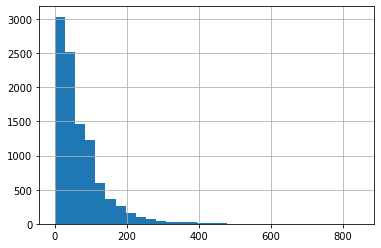

In [47]:
seq_len = [len(i.split()) for i in data_df['preprocess_comment']]

pd.Series(seq_len).hist(bins = 30)

# Load BPE, Vocab of PhoBERT and DataGen

In [48]:
from transformers import AutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [49]:
def collate_batch(batch):
  input_ids = []
  attention_masks = []
  imgs = []
  img_len = []
  labels = []
  for bt in batch:
    imgs.extend(bt[0])
    img_len.append(len(bt[0]))
    labels.append(bt[1])

  imgs_torch = torch.stack(imgs)
  labels = torch.LongTensor(labels)

  return  imgs_torch, img_len, labels

In [50]:
trans = T.ToTensor()
RANDOM_SEED = 0
MAX_LEN = 150


class SentimentData(Dataset):
  def __init__(self, data, transform = None):
    self.df = data.reset_index(drop=True)
    self.transform = transform
  def __len__(self):
    # print('Size',len(self.df))
    return len(self.df)  
  def __getitem__(self,idx):
    
    img_list = []
    for path in self.df['image_urls'][idx].split(","):
#       img_path = '/' + path.split('/')[-1]
      img = Image.open(data_zip.open(path))
      if self.transform is not None:
        img = self.transform(img)
      img_list.append(img)

    # print(text.shape)
    # text = ' '.join(text[0])
    label = self.df["label"][idx]

    return ( img_list, label)

class SentimentDataModule(pl.LightningDataModule):
    
  def __init__(self, data, batch_size: int = 8, test_size = 0.2):
      super().__init__()
      self.test_size = test_size
      self.data = data
      self.batch_size = batch_size
      self.train_data = ''
      self.val_data = ''
      self.test_data = ''

  def prepare_data(self):
      self.train_data, self.val_data = train_test_split(self.data, test_size = self.test_size, random_state=RANDOM_SEED, stratify = self.data['label'])
      self.test_data, self.val_data = train_test_split(self.val_data,test_size = 0.5, random_state=RANDOM_SEED, stratify = self.val_data['label'])
      print(self.data['label'].value_counts())
      print(self.train_data['label'].value_counts())
      print(self.val_data['label'].value_counts())
      print(self.test_data['label'].value_counts())

  def setup(self, stage = None):
      train_transform = T.Compose([
       T.Resize([299, 299]), T.RandomHorizontalFlip(), T.RandomRotation(10),
        T.ToTensor(), 
          T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
      ])
      val_transform = T.Compose([
        T.Resize([299, 299]), T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
      ])
      test_transform = T.Compose([
        T.Resize([299, 299]), T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
      ])
      self.train = SentimentData(self.train_data, train_transform)
      self.val = SentimentData(self.val_data, val_transform)
      self.test = SentimentData(self.test_data, test_transform)


  def train_dataloader(self):
      return DataLoader(self.train, batch_size=self.batch_size, shuffle=True, collate_fn=collate_batch)

  def val_dataloader(self):
      return DataLoader(self.val, batch_size=self.batch_size, collate_fn=collate_batch)

  def test_dataloader(self):
      return DataLoader(self.test, batch_size=self.batch_size, collate_fn=collate_batch)

  

In [51]:
# Do some Test with data
if __name__ == "__main__":
  dm = SentimentDataModule(data_df)
  dm.prepare_data()
  dm.setup()
  for step, bat in enumerate(dm.train_dataloader()):
    if step > 0: break
    print(step)
    print(bat[0].shape)
    print(sum(bat[1]))
    print(len(bat[2]))

1    6952
0    3023
Name: label, dtype: int64
1    5562
0    2418
Name: label, dtype: int64
1    695
0    303
Name: label, dtype: int64
1    695
0    302
Name: label, dtype: int64
0
torch.Size([11, 3, 299, 299])
11
8


In [52]:
bat[0].shape

torch.Size([9, 3, 299, 299])

In [53]:
!nvidia-smi

Mon Apr 11 23:50:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:5E:00.0 Off |                  N/A |
|  0%   26C    P8     1W / 250W |      3MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:86:00.0 Off |                  N/A |
|  0%   

In [54]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Computation device: cuda:1



# PhoBERT

In [55]:
# from transformers import RobertaModel, RobertaConfig, AdamW, AutoModel
# from transformers import RobertaForSequenceClassification

# pretrained_config_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/config.json"
# pretrained_model_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/model.bin"

In [56]:
# class Bert_Lstm(nn.Module):
#   def __init__(self):
#     super().__init__()
#     self.PhoBERT = AutoModel.from_pretrained("vinai/phobert-base")

#     self.lstm = nn.LSTM(input_size=768, hidden_size=128, num_layers= 1, batch_first=True)
  
#   def forward(self, texts):
#     bert_out = self.PhoBERT(texts['input_ids'],token_type_ids=None, attention_mask = texts['attention_mask'])
#     bert_out = bert_out['last_hidden_state']
#     out, _ = self.lstm(bert_out)
#     feature_extract = out[:,-1,:].contiguous()

#     return feature_extract

In [57]:
# # This time, the output's 2nd dimension is 3, indicating that there were 3 outputs given by the LSTM. 
# # This corresponds to the length of our input sequence. 
# # For the use cases where we'll need an output at every time step (many-to-many), such as Text Generation, the output of each time step can be extracted directly from the 2nd dimension and fed into a fully connected layer. 
# # For text classification tasks (many-to-one), such as Sentiment Analysis, the last output can be taken to be fed into a classifier.

# pho_test = Bert_Lstm()
# pho_test
# # oooo = pho_test('iiii')
# for name, child in pho_test.named_children():
#   print(name)

# InceptionV3

In [58]:
from torchvision.models import inception_v3

In [59]:
class Inception(nn.Module):
  def __init__(self):
    super(Inception,self).__init__()
    self.incept = inception_v3(pretrained = True,progress = True,aux_logits= False,transform_input = False)
    self.incept_sequen = nn.Sequential(*list(self.incept.children())[:-3])
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.drop = nn.Dropout(p=0.4)
#     self.flat
#     self.flat = nn.Linear(2048, 128)
#     self.cl = nn.Linear(2048,3)
    self.ffn = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
#             nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
#             nn.Dropout(0.2),
            nn.Linear(128, 2),
        )

  def process(self, feature, len_img_list):
    max_fea = torch.zeros(len(len_img_list), 2048, feature.shape[-1], feature.shape[-1]).to(device)
    start = 0
    for idx, num in enumerate(len_img_list):
      max_fea[idx] = feature[start:start+num].max(0)[0]
      start += num

    return max_fea
  

  def forward(self, image, len_img_list):
    feature = self.incept_sequen(image)
#     print(feature.shape)
    feature = self.process(feature, len_img_list)
#     print(feature.shape)
    feature = self.avgpool(feature)
#     print(feature.shape)
    feature = self.drop(feature)
#     print(feature.shape)

    img_fea = feature.reshape(-1, 2048)
#     img_fea = feature.contiguous().view(-1, 2048)
    # out = self.avgpool(feature)
    # out = out.contiguous().view(-1, 2048)
#     out = self.process(img_fea, len_img_list)
    logits = self.ffn(img_fea)
#     logits = self.cl(img_fea)
    
    return logits

In [60]:
# test_mod = Inception()
# test_mod.to(device)
# i1 = bat[0].to(device)
# # i2 = bat[1].to(device)
# ot = test_mod(i1, bat[1])

In [61]:
# ot.shape

In [62]:
# mod = inception_v3(pretrained = True,progress = True,aux_logits= False,transform_input = False)
# inc = nn.Sequential(*list(mod.children())[:-1])
# inc

In [63]:
# a = torch.rand(16, 3,299,299)
# ot = inc(a)
# ot.shape

In [64]:
# test = Inception()
# ot = test(a)

In [65]:
# !pip install tensorflow

In [66]:
# from tensorflow.keras.applications.inception_v3 import InceptionV3
# from tensorflow.keras import layers
# from tensorflow.keras import models
# from tensorflow.keras.models import Model

# basemodel = InceptionV3(weights='imagenet', include_top=False, input_tensor=layers.Input(shape=(299, 299, 3)))
# x = basemodel.output
# # t = layers.AveragePooling2D(pool_size=(8, 8), name='AVG_Pooling')(x)
# model_cnn = Model(basemodel.input, x)

# basemodel.summary()

In [67]:
# !pip install tensorflow

In [68]:
# ou = model_cnn(np.random.rand(1,299,299,3))

In [69]:
# ou.shape

# Multimodal (no pytorch-lightning)

In [70]:
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

In [71]:
class LRScheduler():
    def __init__(
        self, optimizer, patience=1, min_lr=1e-6, factor=0.1
    ):
        self.optimizer = optimizer
        self.patience = patience
        self.min_lr = min_lr
        self.factor = factor
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
                self.optimizer,
                mode='max',
                patience=self.patience,
                factor=self.factor,
                min_lr=self.min_lr,
                verbose=True
            )
    def __call__(self, val_loss):
        self.lr_scheduler.step(val_loss)

class EarlyStopping():
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [72]:
# class Concatmodal(nn.Module):
#   def __init__(self):
#     super(Concatmodal,self).__init__()
#     # self.loss_module = nn.CrossEntropyLoss()
#     self.BERT = Bert_Lstm()
#     self.incept = Inception()
#     self.dense = nn.Linear(256,256)
#     self.cl = nn.Linear(256,3)
#     # self.bpe_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/bpe.codes"
#     # self.vocab_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/dict.txt"
  
#   def forward(self, image, inputs, len_img_list, labels=None):
#     for key in inputs:
#         inputs[key] = inputs[key].to(device)
#     image = image.to(device)

#     fea1 = self.BERT(inputs)
#     fea2 = self.incept(image, len_img_list)
#     cat = torch.cat((fea1, fea2), 1)
#     out = self.cl(cat)

#     return out


In [73]:
def fit(model, dm, criterion, optimizer, epoch):
  running_loss = 0.0
  train_running_loss = 0.0
  # running_correct = 0
  reporting_step = 100

  counter = 0
  # total = 0

  model.train()

  soft_m = nn.Softmax(dim=-1)
  train_preds = np.array([])
  train_labels = np.array([])

  for i, (images, len_img_list, labels) in enumerate(tqdm(dm.train_dataloader())):
      counter += 1
      labels = labels.to(device)
      images = images.to(device)
    
      optimizer.zero_grad()
    
      outputs = model(images, len_img_list)
      loss = criterion(outputs, labels)

      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      train_running_loss += loss.item()
      output_scores = soft_m(outputs)
      predictions = torch.argmax(output_scores, dim=-1)

      predictions = predictions.cpu().numpy()
      labels = labels.cpu().numpy()
      # _, preds = torch.max(outputs.data, 1)
      train_preds = np.concatenate((train_preds, predictions), axis=0)
      train_labels = np.concatenate((train_labels, labels), axis=0)

      if i % reporting_step == reporting_step-1:
            print(f"Epoch {epoch} Step {i} ave_loss {running_loss/reporting_step:0.4f}")
            running_loss = 0.0
  train_loss = train_running_loss / counter
  reports = classification_report(train_labels, train_preds, output_dict=True)
  print(confusion_matrix(train_labels, train_preds))
  train_ac = classification_report(train_labels, train_preds, output_dict=True)['macro avg']['f1-score']

  return train_loss, train_ac

In [74]:
# b = torch.rand(1,3, requires_grad=True)
# print(b.requires_grad)

In [75]:
# m = torch.argmax(b, dim=-1)
# print(m.requires_grad)

In [76]:
def validation(model, dm, criterion):
  model.eval()
  val_running_loss = 0.0
#   val_preds = torch.tensor([], device=device)
#   val_labels = torch.tensor([], device = device)
  val_preds = np.array([])
  val_labels = np.array([])

  soft_m = nn.Softmax(dim=-1)

  counter = 0

  with torch.no_grad():
    for i, (images, len_img_list, labels) in enumerate(dm.val_dataloader()):
        counter += 1
        labels = labels.to(device)
        images = images.to(device)

        outputs = model(images, len_img_list)

        loss = criterion(outputs, labels)
        output_scores = soft_m(outputs)
        predictions = torch.argmax(output_scores, dim=-1)
        
        predictions = predictions.cpu().numpy()
        labels = labels.cpu().numpy()
#         output_scores = output_scores.cpu().numpy()

        val_running_loss += loss.item()
        val_preds = np.concatenate((val_preds, predictions), axis=0)
        val_labels = np.concatenate((val_labels, labels), axis=0)
    
#   val_preds = val_preds.cpu().numpy()
#   val_labels = val_labels.cpu().numpy()

  val_loss = val_running_loss / counter
  print(classification_report(val_labels, val_preds))
  print(confusion_matrix(val_labels, val_preds))
#   val_ac = accuracy_score(val_labels, val_preds)
  val_ac = classification_report(val_labels, val_preds, output_dict=True)['macro avg']['f1-score']


  return val_loss, val_ac


In [77]:
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score

def testing(model, dm):
  model.eval()
  test_running_loss = 0.0
  counter = 0
  test_preds = torch.tensor([], device=device)
  test_labels = torch.tensor([], device = device)

  soft_m = nn.Softmax(dim=-1)


  with torch.no_grad():
    for i, ( images, inputs, labels) in enumerate(dm.test_dataloader()):
        counter += 1
        labels = labels.to(device)
        images = images.to(device)

        outputs = model(images, inputs)

        output_scores = soft_m(outputs)
        predictions = torch.argmax(output_scores, dim=-1)

        test_preds = torch.cat((test_preds, predictions), dim=0)
        test_labels = torch.cat((test_labels, labels), dim=0)

        # loss = criterion(outputs, labels)
        # test_running_loss += loss.item()
    
  test_preds = test_preds.cpu().numpy()
  test_labels = test_labels.cpu().numpy()
       
  print('test', classification_report(test_labels, test_preds))
  print('test_ac', accuracy_score(test_labels, test_preds))
  print('Macro_f1', classification_report(test_labels, test_preds, output_dict=True)['macro avg']['f1-score'])
  print('Confusion', confusion_matrix(test_labels, test_preds))

  # test_loss = test_running_loss / counter



In [78]:
# (t, i ,l) = next(iter(dm.train_dataloader()))
# mo = Concatmodal()
# ou = mo(i, t)
# print(ou)
# sf = nn.Softmax(dim=-1)
# ou = sf(ou)
# print(ou)
# ou = torch.argmax(ou, dim=-1)
# print(ou)

In [79]:
# testing(mo, dm)

In [80]:
def save_checkpoint(state, filename='my_checkpoint_incept_seed7_bt8_fc_2048_re512_re128_1e-3.pth.tar'):
    print('Saving....'+ filename)
    torch.save(state, filename)

In [81]:
def save_checkpoint1(state, filename='my_checkpoint_incept_seed7_bt8_fc_2048_re512_re128_1e-3_f1.pth.tar'):
    print('Saving....'+ filename)
    torch.save(state, filename)

In [82]:
%ls

CNN.ipynb
Inception-Copy1.ipynb
Inception.ipynb
Inception-VotingMultimodal.ipynb
local1_folder_temp.zip
local1_folder.zip
Multimodal_newmodel.ipynb
Multimodal_newmodel-weight.ipynb
my_checkpoint_incept_seed0_bt8_fc_2048_re512_re128_1e-3.pth.tar
my_checkpoint_incept_seed7_bt8_fc_2048_re512_re128_1e-3_f1.pth.tar
my_checkpoint_incept_seed7_bt8_fc_2048_re512_re128_1e-3.pth.tar
my_checkpoint_incept_voting_f1.pth.tar
my_checkpoint_incept_voting.pth.tar
my_checkpoint_multi_bt_8_mrTrong_f1.pth.tar
my_checkpoint_multi_bt_8_mrTrong_f1_seed7.pth.tar
my_checkpoint_multi_bt_8_mrTrong.pth.tar
my_checkpoint_multi_bt_8_mrTrong_seed7.pth.tar
my_checkpoint_multivoting_20_label01_freeze_adam_normalize_img_f1_fc2048512.pth.tar
my_checkpoint_multivoting_20_label01_freeze_adam_normalize_img_f1_nodrop.pth.tar
my_checkpoint_multivoting_20_label01_freeze_adam_normalize_img_f1.pth.tar
my_checkpoint_multivoting_20_label01_freeze_adam_normalize_img_fc2048512.pth.tar
my_checkpoint_multivoting_20_label01_freeze_ada

In [83]:
# model = Concatmodal()
# total_params = sum(p.numel() for p in model.parameters())
# print(f"{total_params:,} total parameters.")
# total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(f"{total_trainable_params:,} training parameters.")

In [102]:
def freeze(model):  
  # for param in model.BERT.PhoBERT.parameters():
  #   param.requires_grad = False
  for param in model.incept.parameters():
    param.requires_grad = False
  return model

def unfreeze(model):  
  for param in model.incept.incept.parameters():
    param.requires_grad = True
    # print(param)
  return model

In [103]:
model = Inception()
model

Inception(
  (incept): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_4a_3x3): BasicC

In [104]:
model = freeze(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

24,949,578 total parameters.
1,115,010 training parameters.


In [85]:
for name, child in model.incept_sequen.named_children():
#     print(name)
    if name in ['17']:
        print(name + ' has been unfrozen.')
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False

17 has been unfrozen.


In [86]:
# for name, child in model.incept_sequen.named_children():
#     print(name)

In [108]:
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

24,949,578 total parameters.
7,191,810 training parameters.


In [88]:
# model = Inception()
# model = freeze(model)
# model.to(device)

In [89]:
# model = freeze(model)
# model.to(device)

In [78]:
# model

In [87]:
from sklearn.utils.class_weight import compute_class_weight

class_weights=compute_class_weight(class_weight='balanced', classes=np.unique(dm.train_data['label']), y=dm.train_data['label'])
class_weights=torch.tensor(class_weights,dtype=torch.float).to(device)

In [105]:
from torch.optim import lr_scheduler
import time

train_loss_list=[]
epoch_list=[]
val_loss_list=[]
val_f1_list=[]
train_f1_list=[]

#define model
# model = Concatmodal()
# model = freeze(model)
model.to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
# define hyper
# grouped_params = [
#     {"params": [p for n, p in roberta_params], "lr": 1e-5},
#     # {"params": [p for n, p in classifier_params], "lr": 3e-3}
# ]
# optimizer = torch.optim.Adam([
#         {'params': model.BERT.lstm.parameters()},  
#         {'params': model.incept.flat.parameters()},  
#         {'params': model.dense.parameters()},       
#         {'params': model.cl.parameters()},       
#         {'params': model.BERT.PhoBERT.parameters(), 'lr': 2e-5},
#         {'params': model.incept.incept.parameters(), 'lr': 2e-5}
#     ], lr=3e-3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# optimizer = torch.optim.Adam([
#     {"params": model.ffn.parameters()},
#     {"params": filter(lambda x: x.requires_grad, model.incept_sequen.parameters()), "lr": 1e-4},
# ], lr=1e-3)
#training
# def training(model, optimizer):
# define hyper
criterion = nn.CrossEntropyLoss(weight=class_weights)
epochs = 20
lr_scheduler = LRScheduler(optimizer)
early_stopping = EarlyStopping()
min_loss = np.Inf
max_f1 = 0

since = time.time()

for epoch in range(epochs):
  print(f"Epoch {epoch} of {epochs}")
  train_epoch_loss, train_ac = fit(
        model, dm, criterion, optimizer, epoch
    )
  val_epoch_loss, val_epoch_ac = validation(
        model, dm, criterion
    )
  lr_scheduler(val_epoch_ac)
    
  print('Train acc', train_ac)
  print(f"Train Loss: {train_epoch_loss:.4f}")
  print(f'Val Loss: {val_epoch_loss:.4f}')
  print(f'Val Acc: {val_epoch_ac:.4f}')

      
  train_loss_list.append(train_epoch_loss)
  train_f1_list.append(train_ac)
  val_loss_list.append(val_epoch_loss)
  val_f1_list.append(val_epoch_ac)
  epoch_list.append(epoch)

  checkpoint ={'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch, 'val_epoch_loss':val_epoch_loss }
  if (min_loss >= val_epoch_loss):
      print('Better ver saved')
      min_loss = val_epoch_loss
      save_checkpoint(checkpoint)
        
  if (val_epoch_ac >= max_f1):
      checkpoint ={'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch, 'loss': val_epoch_loss, "f1": val_epoch_ac}
      print('Better ver saved')
      max_f1 = val_epoch_ac
      # filename = 'model{loss}-{epoch}.pth.tar'
      # filename = filename.format(loss= min_loss, epoch= epoch)
      save_checkpoint1(checkpoint)
    
  early_stopping(val_epoch_loss)
  if early_stopping.early_stop:
      break
    
time_elapsed = time.time() - since
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
testing(model, dm)

24,949,578 total parameters.
1,115,010 training parameters.
Epoch 0 of 20


 10%|████                                     | 100/998 [00:23<03:48,  3.93it/s]

Epoch 0 Step 99 ave_loss 0.6902


 20%|████████▎                                | 201/998 [00:46<02:41,  4.94it/s]

Epoch 0 Step 199 ave_loss 0.6655


 30%|████████████▎                            | 300/998 [01:10<02:43,  4.27it/s]

Epoch 0 Step 299 ave_loss 0.6767


 40%|████████████████▍                        | 400/998 [01:33<02:04,  4.82it/s]

Epoch 0 Step 399 ave_loss 0.6621


 50%|████████████████████▌                    | 501/998 [01:55<01:36,  5.17it/s]

Epoch 0 Step 499 ave_loss 0.6414


 60%|████████████████████████▋                | 600/998 [02:17<01:11,  5.58it/s]

Epoch 0 Step 599 ave_loss 0.6667


 70%|████████████████████████████▊            | 700/998 [02:39<01:25,  3.47it/s]

Epoch 0 Step 699 ave_loss 0.6538


 80%|████████████████████████████████▊        | 800/998 [03:04<00:54,  3.60it/s]

Epoch 0 Step 799 ave_loss 0.6406


 90%|████████████████████████████████████▉    | 900/998 [03:29<00:21,  4.65it/s]

Epoch 0 Step 899 ave_loss 0.6607


100%|█████████████████████████████████████████| 998/998 [03:51<00:00,  4.30it/s]


[[1209 1209]
 [1685 3877]]
              precision    recall  f1-score   support

         0.0       0.53      0.47      0.50       303
         1.0       0.78      0.82      0.80       695

    accuracy                           0.71       998
   macro avg       0.66      0.65      0.65       998
weighted avg       0.71      0.71      0.71       998

[[143 160]
 [125 570]]
Train acc 0.5917038269531921
Train Loss: 0.6608
Val Loss: 0.6230
Val Acc: 0.6504
Better ver saved
Saving....my_checkpoint_incept_seed7_bt8_fc_2048_re512_re128_1e-3.pth.tar
Better ver saved
Saving....my_checkpoint_incept_seed7_bt8_fc_2048_re512_re128_1e-3_f1.pth.tar
Epoch 1 of 20


 10%|████                                     | 100/998 [00:22<03:24,  4.40it/s]

Epoch 1 Step 99 ave_loss 0.6317


 20%|████████▏                                | 200/998 [00:43<03:03,  4.34it/s]

Epoch 1 Step 199 ave_loss 0.6308


 30%|████████████▎                            | 300/998 [01:06<02:47,  4.18it/s]

Epoch 1 Step 299 ave_loss 0.6408


 40%|████████████████▍                        | 400/998 [01:29<02:31,  3.96it/s]

Epoch 1 Step 399 ave_loss 0.6332


 50%|████████████████████▌                    | 501/998 [01:53<01:36,  5.17it/s]

Epoch 1 Step 499 ave_loss 0.6375


 60%|████████████████████████▋                | 601/998 [02:16<01:30,  4.41it/s]

Epoch 1 Step 599 ave_loss 0.6516


 70%|████████████████████████████▊            | 700/998 [02:39<01:15,  3.96it/s]

Epoch 1 Step 699 ave_loss 0.6235


 80%|████████████████████████████████▊        | 800/998 [03:01<00:37,  5.23it/s]

Epoch 1 Step 799 ave_loss 0.6353


 90%|████████████████████████████████████▉    | 900/998 [03:24<00:22,  4.40it/s]

Epoch 1 Step 899 ave_loss 0.6210


100%|█████████████████████████████████████████| 998/998 [03:48<00:00,  4.37it/s]


[[1193 1225]
 [1266 4296]]
              precision    recall  f1-score   support

         0.0       0.49      0.65      0.56       303
         1.0       0.82      0.70      0.76       695

    accuracy                           0.69       998
   macro avg       0.65      0.68      0.66       998
weighted avg       0.72      0.69      0.70       998

[[196 107]
 [206 489]]
Train acc 0.6322382731036609
Train Loss: 0.6344
Val Loss: 0.6004
Val Acc: 0.6568
Better ver saved
Saving....my_checkpoint_incept_seed7_bt8_fc_2048_re512_re128_1e-3.pth.tar
Better ver saved
Saving....my_checkpoint_incept_seed7_bt8_fc_2048_re512_re128_1e-3_f1.pth.tar
Epoch 2 of 20


 10%|████                                     | 100/998 [00:23<03:55,  3.82it/s]

Epoch 2 Step 99 ave_loss 0.6143


 20%|████████▏                                | 200/998 [00:46<02:50,  4.68it/s]

Epoch 2 Step 199 ave_loss 0.6147


 30%|████████████▎                            | 300/998 [01:11<03:02,  3.83it/s]

Epoch 2 Step 299 ave_loss 0.6185


 40%|████████████████▍                        | 400/998 [01:34<02:02,  4.89it/s]

Epoch 2 Step 399 ave_loss 0.6197


 50%|████████████████████▌                    | 501/998 [01:57<01:39,  5.02it/s]

Epoch 2 Step 499 ave_loss 0.6357


 60%|████████████████████████▋                | 600/998 [02:19<01:34,  4.20it/s]

Epoch 2 Step 599 ave_loss 0.6288


 70%|████████████████████████████▊            | 700/998 [02:42<00:58,  5.11it/s]

Epoch 2 Step 699 ave_loss 0.6182


 80%|████████████████████████████████▉        | 801/998 [03:04<00:41,  4.79it/s]

Epoch 2 Step 799 ave_loss 0.6118


 90%|█████████████████████████████████████    | 901/998 [03:26<00:20,  4.74it/s]

Epoch 2 Step 899 ave_loss 0.6156


100%|█████████████████████████████████████████| 998/998 [03:48<00:00,  4.36it/s]


[[1257 1161]
 [1226 4336]]
              precision    recall  f1-score   support

         0.0       0.56      0.53      0.55       303
         1.0       0.80      0.82      0.81       695

    accuracy                           0.73       998
   macro avg       0.68      0.68      0.68       998
weighted avg       0.73      0.73      0.73       998

[[162 141]
 [125 570]]
Train acc 0.6485571195464575
Train Loss: 0.6208
Val Loss: 0.5994
Val Acc: 0.6800
Better ver saved
Saving....my_checkpoint_incept_seed7_bt8_fc_2048_re512_re128_1e-3.pth.tar
Better ver saved
Saving....my_checkpoint_incept_seed7_bt8_fc_2048_re512_re128_1e-3_f1.pth.tar
Epoch 3 of 20


 10%|████                                     | 100/998 [00:23<03:09,  4.74it/s]

Epoch 3 Step 99 ave_loss 0.6125


 20%|████████▏                                | 200/998 [00:46<03:14,  4.09it/s]

Epoch 3 Step 199 ave_loss 0.6306


 30%|████████████▎                            | 300/998 [01:08<02:42,  4.29it/s]

Epoch 3 Step 299 ave_loss 0.6305


 40%|████████████████▍                        | 400/998 [01:31<02:03,  4.85it/s]

Epoch 3 Step 399 ave_loss 0.6171


 50%|████████████████████▌                    | 500/998 [01:53<01:59,  4.18it/s]

Epoch 3 Step 499 ave_loss 0.6270


 60%|████████████████████████▋                | 600/998 [02:17<01:19,  4.99it/s]

Epoch 3 Step 599 ave_loss 0.6131


 70%|████████████████████████████▊            | 701/998 [02:42<01:07,  4.41it/s]

Epoch 3 Step 699 ave_loss 0.6167


 80%|████████████████████████████████▉        | 801/998 [03:06<00:42,  4.60it/s]

Epoch 3 Step 799 ave_loss 0.6442


 90%|█████████████████████████████████████    | 901/998 [03:29<00:21,  4.53it/s]

Epoch 3 Step 899 ave_loss 0.6042


100%|█████████████████████████████████████████| 998/998 [03:51<00:00,  4.31it/s]


[[1357 1061]
 [1363 4199]]
              precision    recall  f1-score   support

         0.0       0.57      0.43      0.49       303
         1.0       0.78      0.86      0.82       695

    accuracy                           0.73       998
   macro avg       0.68      0.65      0.65       998
weighted avg       0.72      0.73      0.72       998

[[131 172]
 [ 97 598]]
Train acc 0.6521164627308285
Train Loss: 0.6204
Val Loss: 0.6064
Val Acc: 0.6549
INFO: Early stopping counter 1 of 5
Epoch 4 of 20


 10%|████▏                                    | 101/998 [00:23<03:13,  4.64it/s]

Epoch 4 Step 99 ave_loss 0.6281


 20%|████████▎                                | 201/998 [00:46<02:24,  5.53it/s]

Epoch 4 Step 199 ave_loss 0.5962


 30%|████████████▎                            | 300/998 [01:09<02:25,  4.81it/s]

Epoch 4 Step 299 ave_loss 0.6286


 40%|████████████████▍                        | 400/998 [01:33<01:56,  5.12it/s]

Epoch 4 Step 399 ave_loss 0.6006


 50%|████████████████████▌                    | 501/998 [01:55<01:56,  4.28it/s]

Epoch 4 Step 499 ave_loss 0.6097


 60%|████████████████████████▋                | 601/998 [02:18<01:19,  5.00it/s]

Epoch 4 Step 599 ave_loss 0.6207


 70%|████████████████████████████▊            | 701/998 [02:43<01:02,  4.77it/s]

Epoch 4 Step 699 ave_loss 0.6039


 80%|████████████████████████████████▉        | 801/998 [03:04<00:34,  5.74it/s]

Epoch 4 Step 799 ave_loss 0.6175


 90%|█████████████████████████████████████    | 901/998 [03:27<00:18,  5.12it/s]

Epoch 4 Step 899 ave_loss 0.6124


100%|█████████████████████████████████████████| 998/998 [03:49<00:00,  4.36it/s]


[[1314 1104]
 [1258 4304]]
              precision    recall  f1-score   support

         0.0       0.54      0.54      0.54       303
         1.0       0.80      0.80      0.80       695

    accuracy                           0.72       998
   macro avg       0.67      0.67      0.67       998
weighted avg       0.72      0.72      0.72       998

[[164 139]
 [141 554]]
Epoch 00005: reducing learning rate of group 0 to 1.0000e-04.
Train acc 0.6556694062692385
Train Loss: 0.6158
Val Loss: 0.5976
Val Acc: 0.6689
Better ver saved
Saving....my_checkpoint_incept_seed7_bt8_fc_2048_re512_re128_1e-3.pth.tar
Epoch 5 of 20


 10%|████                                     | 100/998 [00:22<04:12,  3.56it/s]

Epoch 5 Step 99 ave_loss 0.5788


 20%|████████▎                                | 201/998 [00:47<02:37,  5.06it/s]

Epoch 5 Step 199 ave_loss 0.5885


 30%|████████████▎                            | 300/998 [01:11<02:53,  4.03it/s]

Epoch 5 Step 299 ave_loss 0.6093


 40%|████████████████▍                        | 400/998 [01:34<02:22,  4.19it/s]

Epoch 5 Step 399 ave_loss 0.6255


 50%|████████████████████▌                    | 500/998 [01:56<01:46,  4.69it/s]

Epoch 5 Step 499 ave_loss 0.5974


 60%|████████████████████████▋                | 601/998 [02:20<01:34,  4.20it/s]

Epoch 5 Step 599 ave_loss 0.6020


 70%|████████████████████████████▊            | 700/998 [02:40<01:02,  4.76it/s]

Epoch 5 Step 699 ave_loss 0.5695


 80%|████████████████████████████████▊        | 800/998 [03:05<00:49,  3.99it/s]

Epoch 5 Step 799 ave_loss 0.5840


 90%|█████████████████████████████████████    | 901/998 [03:27<00:19,  4.85it/s]

Epoch 5 Step 899 ave_loss 0.6131


100%|█████████████████████████████████████████| 998/998 [03:48<00:00,  4.36it/s]


[[1395 1023]
 [1187 4375]]
              precision    recall  f1-score   support

         0.0       0.50      0.62      0.56       303
         1.0       0.82      0.73      0.77       695

    accuracy                           0.70       998
   macro avg       0.66      0.68      0.66       998
weighted avg       0.72      0.70      0.70       998

[[189 114]
 [189 506]]
Train acc 0.6781788321167883
Train Loss: 0.5967
Val Loss: 0.5836
Val Acc: 0.6623
Better ver saved
Saving....my_checkpoint_incept_seed7_bt8_fc_2048_re512_re128_1e-3.pth.tar
Epoch 6 of 20


 10%|████                                     | 100/998 [00:22<02:53,  5.17it/s]

Epoch 6 Step 99 ave_loss 0.5993


 20%|████████▏                                | 200/998 [00:45<02:57,  4.51it/s]

Epoch 6 Step 199 ave_loss 0.6049


 30%|████████████▎                            | 301/998 [01:08<02:13,  5.22it/s]

Epoch 6 Step 299 ave_loss 0.5975


 40%|████████████████▍                        | 401/998 [01:32<02:00,  4.97it/s]

Epoch 6 Step 399 ave_loss 0.6086


 50%|████████████████████▌                    | 500/998 [01:56<01:31,  5.44it/s]

Epoch 6 Step 499 ave_loss 0.6218


 60%|████████████████████████▋                | 601/998 [02:20<01:48,  3.66it/s]

Epoch 6 Step 599 ave_loss 0.6026


 70%|████████████████████████████▊            | 700/998 [02:41<01:24,  3.53it/s]

Epoch 6 Step 699 ave_loss 0.5953


 80%|████████████████████████████████▊        | 800/998 [03:05<00:37,  5.26it/s]

Epoch 6 Step 799 ave_loss 0.5853


 90%|████████████████████████████████████▉    | 900/998 [03:28<00:21,  4.49it/s]

Epoch 6 Step 899 ave_loss 0.5979


100%|█████████████████████████████████████████| 998/998 [03:50<00:00,  4.32it/s]


[[1411 1007]
 [1327 4235]]
              precision    recall  f1-score   support

         0.0       0.54      0.59      0.56       303
         1.0       0.81      0.78      0.80       695

    accuracy                           0.72       998
   macro avg       0.68      0.68      0.68       998
weighted avg       0.73      0.72      0.73       998

[[178 125]
 [152 543]]
Epoch 00007: reducing learning rate of group 0 to 1.0000e-05.
Train acc 0.6656462035007578
Train Loss: 0.6019
Val Loss: 0.5878
Val Acc: 0.6796
INFO: Early stopping counter 1 of 5
Epoch 7 of 20


 10%|████▏                                    | 101/998 [00:23<03:06,  4.80it/s]

Epoch 7 Step 99 ave_loss 0.6015


 20%|████████▏                                | 200/998 [00:47<02:28,  5.36it/s]

Epoch 7 Step 199 ave_loss 0.5922


 30%|████████████▎                            | 300/998 [01:11<02:24,  4.82it/s]

Epoch 7 Step 299 ave_loss 0.6211


 40%|████████████████▍                        | 400/998 [01:34<02:33,  3.90it/s]

Epoch 7 Step 399 ave_loss 0.5891


 50%|████████████████████▌                    | 501/998 [01:57<01:41,  4.88it/s]

Epoch 7 Step 499 ave_loss 0.5902


 60%|████████████████████████▋                | 601/998 [02:21<01:43,  3.83it/s]

Epoch 7 Step 599 ave_loss 0.6169


 70%|████████████████████████████▊            | 700/998 [02:43<01:06,  4.48it/s]

Epoch 7 Step 699 ave_loss 0.5953


 80%|████████████████████████████████▊        | 800/998 [03:08<00:46,  4.28it/s]

Epoch 7 Step 799 ave_loss 0.6069


 90%|████████████████████████████████████▉    | 900/998 [03:31<00:27,  3.50it/s]

Epoch 7 Step 899 ave_loss 0.6058


100%|█████████████████████████████████████████| 998/998 [03:53<00:00,  4.27it/s]


[[1452  966]
 [1374 4188]]
              precision    recall  f1-score   support

         0.0       0.55      0.58      0.57       303
         1.0       0.81      0.79      0.80       695

    accuracy                           0.73       998
   macro avg       0.68      0.69      0.69       998
weighted avg       0.73      0.73      0.73       998

[[177 126]
 [143 552]]
Train acc 0.6677053410584741
Train Loss: 0.5999
Val Loss: 0.5846
Val Acc: 0.6861
Better ver saved
Saving....my_checkpoint_incept_seed7_bt8_fc_2048_re512_re128_1e-3_f1.pth.tar
INFO: Early stopping counter 2 of 5
Epoch 8 of 20


 10%|████                                     | 100/998 [00:23<04:00,  3.73it/s]

Epoch 8 Step 99 ave_loss 0.6023


 20%|████████▎                                | 201/998 [00:47<02:37,  5.05it/s]

Epoch 8 Step 199 ave_loss 0.6163


 30%|████████████▎                            | 300/998 [01:10<02:45,  4.21it/s]

Epoch 8 Step 299 ave_loss 0.5705


 40%|████████████████▍                        | 400/998 [01:33<02:35,  3.84it/s]

Epoch 8 Step 399 ave_loss 0.5747


 50%|████████████████████▌                    | 500/998 [01:55<01:37,  5.08it/s]

Epoch 8 Step 499 ave_loss 0.5773


 60%|████████████████████████▋                | 600/998 [02:18<01:19,  4.99it/s]

Epoch 8 Step 599 ave_loss 0.6363


 70%|████████████████████████████▊            | 701/998 [02:42<00:56,  5.25it/s]

Epoch 8 Step 699 ave_loss 0.5937


 80%|████████████████████████████████▊        | 800/998 [03:03<00:41,  4.72it/s]

Epoch 8 Step 799 ave_loss 0.5999


 90%|████████████████████████████████████▉    | 900/998 [03:25<00:19,  5.04it/s]

Epoch 8 Step 899 ave_loss 0.5880


100%|█████████████████████████████████████████| 998/998 [03:48<00:00,  4.36it/s]


[[1387 1031]
 [1269 4293]]
              precision    recall  f1-score   support

         0.0       0.53      0.60      0.56       303
         1.0       0.81      0.77      0.79       695

    accuracy                           0.72       998
   macro avg       0.67      0.68      0.68       998
weighted avg       0.73      0.72      0.72       998

[[181 122]
 [159 536]]
Train acc 0.6677140836291633
Train Loss: 0.5964
Val Loss: 0.5841
Val Acc: 0.6776
INFO: Early stopping counter 3 of 5
Epoch 9 of 20


 10%|████                                     | 100/998 [00:22<03:21,  4.46it/s]

Epoch 9 Step 99 ave_loss 0.5784


 20%|████████▏                                | 200/998 [00:45<03:22,  3.93it/s]

Epoch 9 Step 199 ave_loss 0.5740


 30%|████████████▎                            | 300/998 [01:08<03:26,  3.38it/s]

Epoch 9 Step 299 ave_loss 0.5934


 40%|████████████████▍                        | 401/998 [01:29<01:54,  5.23it/s]

Epoch 9 Step 399 ave_loss 0.5951


 50%|████████████████████▌                    | 501/998 [01:52<01:42,  4.84it/s]

Epoch 9 Step 499 ave_loss 0.6386


 60%|████████████████████████▋                | 601/998 [02:15<01:13,  5.41it/s]

Epoch 9 Step 599 ave_loss 0.5923


 70%|████████████████████████████▊            | 700/998 [02:39<00:57,  5.21it/s]

Epoch 9 Step 699 ave_loss 0.5821


 80%|████████████████████████████████▊        | 800/998 [03:01<00:48,  4.04it/s]

Epoch 9 Step 799 ave_loss 0.5936


 90%|████████████████████████████████████▉    | 900/998 [03:23<00:22,  4.42it/s]

Epoch 9 Step 899 ave_loss 0.6003


100%|█████████████████████████████████████████| 998/998 [03:45<00:00,  4.42it/s]


[[1436  982]
 [1282 4280]]
              precision    recall  f1-score   support

         0.0       0.53      0.62      0.57       303
         1.0       0.82      0.76      0.79       695

    accuracy                           0.72       998
   macro avg       0.68      0.69      0.68       998
weighted avg       0.73      0.72      0.72       998

[[189 114]
 [167 528]]
Epoch 00010: reducing learning rate of group 0 to 1.0000e-06.
Train acc 0.6750126061158657
Train Loss: 0.5945
Val Loss: 0.5841
Val Acc: 0.6817
INFO: Early stopping counter 4 of 5
Epoch 10 of 20


 10%|████                                     | 100/998 [00:21<03:01,  4.94it/s]

Epoch 10 Step 99 ave_loss 0.6041


 20%|████████▏                                | 200/998 [00:43<02:16,  5.83it/s]

Epoch 10 Step 199 ave_loss 0.6123


 30%|████████████▎                            | 300/998 [01:07<02:48,  4.13it/s]

Epoch 10 Step 299 ave_loss 0.5662


 40%|████████████████▍                        | 401/998 [01:30<02:04,  4.79it/s]

Epoch 10 Step 399 ave_loss 0.5934


 50%|████████████████████▌                    | 500/998 [01:52<01:59,  4.18it/s]

Epoch 10 Step 499 ave_loss 0.5657


 60%|████████████████████████▋                | 600/998 [02:14<01:12,  5.46it/s]

Epoch 10 Step 599 ave_loss 0.5971


 70%|████████████████████████████▊            | 700/998 [02:38<01:16,  3.92it/s]

Epoch 10 Step 699 ave_loss 0.6044


 80%|████████████████████████████████▊        | 800/998 [03:01<00:49,  4.03it/s]

Epoch 10 Step 799 ave_loss 0.5851


 90%|█████████████████████████████████████    | 901/998 [03:25<00:21,  4.51it/s]

Epoch 10 Step 899 ave_loss 0.5919


100%|█████████████████████████████████████████| 998/998 [03:46<00:00,  4.40it/s]


[[1448  970]
 [1295 4267]]
              precision    recall  f1-score   support

         0.0       0.51      0.62      0.56       303
         1.0       0.82      0.74      0.78       695

    accuracy                           0.70       998
   macro avg       0.66      0.68      0.67       998
weighted avg       0.72      0.70      0.71       998

[[188 115]
 [181 514]]
Train acc 0.6756949604528784
Train Loss: 0.5921
Val Loss: 0.5846
Val Acc: 0.6680
INFO: Early stopping counter 5 of 5
INFO: Early stopping
Training complete in 46m 55s
test               precision    recall  f1-score   support

         0.0       0.53      0.62      0.57       302
         1.0       0.82      0.76      0.79       695

    accuracy                           0.72       997
   macro avg       0.67      0.69      0.68       997
weighted avg       0.73      0.72      0.72       997

test_ac 0.7161484453360081
Macro_f1 0.6792882190130319
Confusion [[188 114]
 [169 526]]


In [89]:
# training(model, optimizer)
print(next(model.parameters()).device)

cuda:1


In [106]:
def show_graph(train_accu, eval_accu, epoch_list, type='F1'):
    plt.plot(epoch_list,train_accu ,'-o')
    plt.plot(epoch_list,eval_accu,'-o')
    plt.xlabel('epoch')
    plt.ylabel(type)
    plt.legend(['Train','Valid'])
    plt.title('Train vs Valid '+type)

    plt.show()

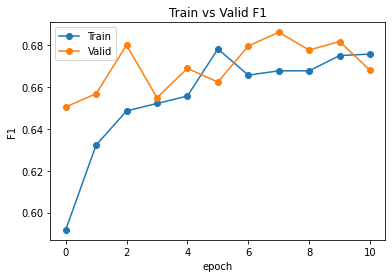

In [107]:
# freeze inception 25
show_graph(train_f1_list, val_f1_list, epoch_list)

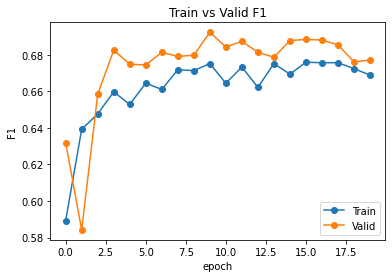

In [91]:
# freeze inception 66
show_graph(train_f1_list, val_f1_list, epoch_list)

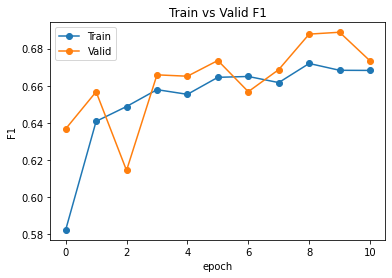

In [87]:
# freeze inception 0
show_graph(train_f1_list, val_f1_list, epoch_list)

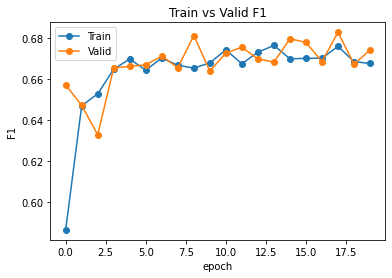

In [87]:
# freeze inception seed 7
show_graph(train_f1_list, val_f1_list, epoch_list)

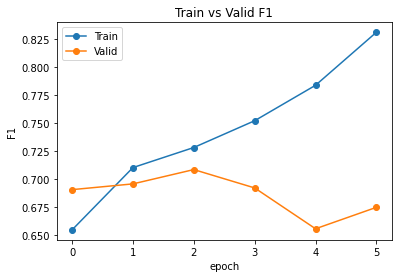

In [112]:
## không freeze layer 17
show_graph(train_f1_list, val_f1_list, epoch_list)

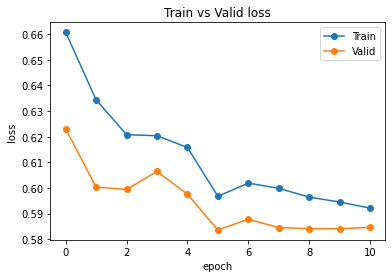

In [108]:
# freeze inception 25
show_graph(train_loss_list, val_loss_list, epoch_list, 'loss')

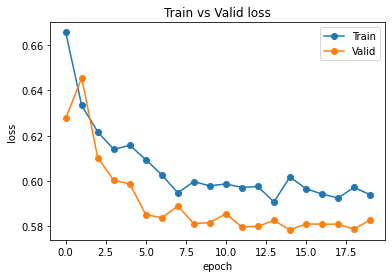

In [92]:
# freeze inception 66
show_graph(train_loss_list, val_loss_list, epoch_list, 'loss')

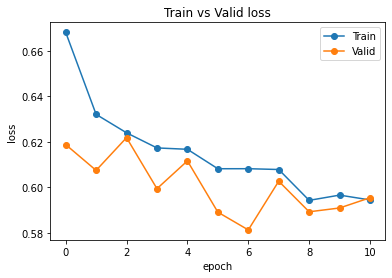

In [88]:
# freeze inception 0
show_graph(train_loss_list, val_loss_list, epoch_list, 'loss')

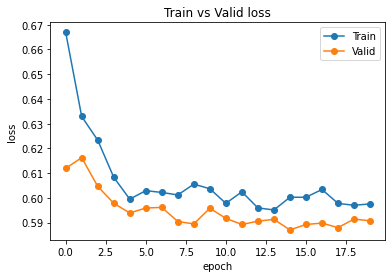

In [88]:
# freeze inception 7
show_graph(train_loss_list, val_loss_list, epoch_list, 'loss')

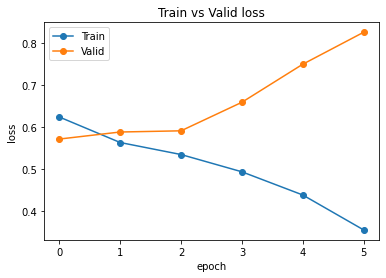

In [113]:
## không freeze layer 17 
show_graph(train_loss_list, val_loss_list, epoch_list, 'loss')

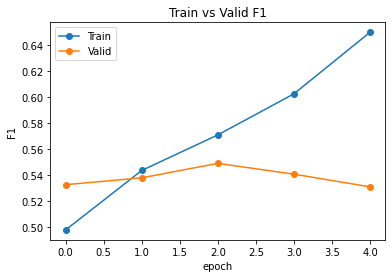

In [110]:
## không freeze 1 layer cuối và train sau khi đã freeze 
show_graph(train_f1_list, val_f1_list, epoch_list)

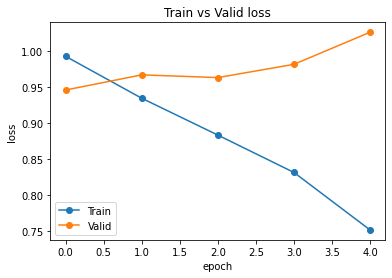

In [111]:
## không freeze 1 layer cuối và train sau khi đã freeze 
show_graph(train_loss_list, val_loss_list, epoch_list, 'loss')

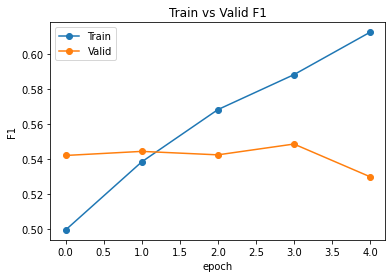

In [96]:
## không freeze 2 layer cuối inception
show_graph(train_f1_list, val_f1_list, epoch_list)

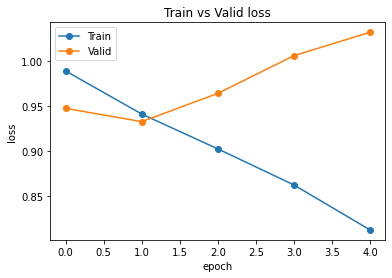

In [97]:
## không freeze 2 layer cuối inception
show_graph(train_loss_list, val_loss_list, epoch_list, 'loss')

In [66]:
epochs = 10
# model = unfreeze(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

for epoch in range(epochs):
  print(f"Epoch {epoch} of {epochs}")
  train_epoch_loss = fit(
        model, dm, criterion, optimizer, epoch
    )
  val_epoch_loss, val_epoch_ac = validation(
        model, dm, criterion
    )
  lr_scheduler(val_epoch_ac)

  early_stopping(val_epoch_loss)
  if early_stopping.early_stop:
      break
  print(f"Train Loss: {train_epoch_loss:.4f}")
  print(f'Val Loss: {val_epoch_loss:.4f}')
  print(f'Val Acc: {val_epoch_ac:.4f}')

  checkpoint ={'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch, 'val_epoch_loss':val_epoch_loss }
  if (min_loss >= val_epoch_loss):
      print('Better ver saved')
      min_loss = val_epoch_loss
      save_checkpoint(checkpoint)

testing(model, dm)

159,621,451 total parameters.
788,611 training parameters.
Epoch 0 of 10
Epoch 0 Step 59 ave_loss 0.5513
Epoch 0 Step 119 ave_loss 0.5471
Epoch 0 Step 179 ave_loss 0.5584
Epoch 0 Step 239 ave_loss 0.5184
Epoch 0 Step 299 ave_loss 0.5201
Epoch 0 Step 359 ave_loss 0.5685
Epoch 0 Step 419 ave_loss 0.5234
Epoch 0 Step 479 ave_loss 0.5464
Epoch 0 Step 539 ave_loss 0.5545
Epoch 0 Step 599 ave_loss 0.5549
Epoch 0 Step 659 ave_loss 0.5650
Epoch 0 Step 719 ave_loss 0.5372
              precision    recall  f1-score   support

         0.0       0.84      0.81      0.82       242
         1.0       0.77      0.87      0.82       551
         2.0       0.63      0.51      0.56       308

    accuracy                           0.75      1101
   macro avg       0.75      0.73      0.73      1101
weighted avg       0.75      0.75      0.75      1101

INFO: Early stopping counter 2 of 5
Train Loss: 0.5450
Val Loss: 0.5903
Val Acc: 0.7530
Epoch 1 of 10
Epoch 1 Step 59 ave_loss 0.5416
Epoch 1 Step 119 

In [109]:
import gc
del model 
gc.collect()

6763

In [110]:
torch.cuda.empty_cache()

In [111]:
PATH = "my_checkpoint_incept_seed7_bt8_fc_2048_re512_re128_1e-3.pth.tar"
checkpoint = torch.load(PATH, map_location=device)
# model = Concatmodal()
model = Inception()
model.load_state_dict(checkpoint['state_dict'])
model.to(device)
print(checkpoint['epoch'])

5


In [112]:
testing(model, dm)

test               precision    recall  f1-score   support

         0.0       0.53      0.66      0.59       302
         1.0       0.84      0.75      0.79       695

    accuracy                           0.72       997
   macro avg       0.69      0.71      0.69       997
weighted avg       0.74      0.72      0.73       997

test_ac 0.7231695085255767
Macro_f1 0.6907067709738333
Confusion [[199 103]
 [173 522]]


In [95]:
testing(model, dm)

test               precision    recall  f1-score   support

         0.0       0.56      0.59      0.58       302
         1.0       0.82      0.80      0.81       695

    accuracy                           0.74       997
   macro avg       0.69      0.69      0.69       997
weighted avg       0.74      0.74      0.74       997

test_ac 0.7352056168505516
Macro_f1 0.691571437945872
Confusion [[179 123]
 [141 554]]


In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.9, weight_decay=5e-4)
optimizer.load_state_dict(checkpoint['optimizer'])

In [71]:
# !conda install opencv 

In [74]:
import cv2
def plot(model):
  model.eval()
  test_preds = torch.tensor([], device=device)
  test_labels = torch.tensor([], device = device)
  test_text = []
  test_img = []
  test_preds = np.array([])
  test_labels = np.array([])

  soft_m = nn.Softmax(dim=-1)
  with torch.no_grad():
    for i, (images, len_img_list, labels) in enumerate(dm.test_dataloader()):
        labels = labels.to(device)
        print(images.shape, len(len_img_list))
        outputs = model(images, len_img_list)

        output_scores = soft_m(outputs)
        predictions = torch.argmax(output_scores, dim=-1)

        test_preds = torch.cat((test_preds, predictions), dim=0)
        test_labels = torch.cat((test_labels, labels), dim=0)
#         for t in texts:
#           test_text.append(t) 
        start = 0
        for i in range(len(len_img_list)):
          test_img.append(images[start: start+1]) 
          start += len_img_list[i]
    
    test_preds = test_preds.cpu().numpy()
    test_labels = test_labels.cpu().numpy()
  i = 1
  plt.figure(figsize=(40,40))
  print(len(test_labels))
  for image, actual_label, label in zip(test_img, test_labels, test_preds):

      if (actual_label == label):

        plt.subplot(4,4,i)
        i+=1
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = T.ToPILImage()(image).convert("RGB")
        plt.imshow(image)
        plt.axis('off')
        plt.title("Actual: {}\n Predicted: {}".format( actual_label, label))
        # plt.xlabel(text)
      else:
        pass
      if (i==17):
        break;
#   plt.savefig('res_freeze_af20epoch.png', bbox_inches='tight')
  plt.show()
  

plot(model)


torch.Size([26, 3, 75, 115]) 8


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [68]:
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

# Multimodal

In [ ]:
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score

class Multimodal(pl.LightningModule):
  def __init__(self, lr_multi, lr_classifier):
    super(Multimodal,self).__init__()
    self.loss_module = nn.CrossEntropyLoss()
    self.BERT = Bert_Lstm()
    self.incept = Inception()
    self.dense = nn.Linear(256,256)
    self.cl = nn.Linear(256,3)
    self.bpe_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/bpe.codes"
    self.vocab_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/dict.txt"
    self.lr_multi = lr_multi
    self.lr_classifier = lr_classifier

    # self.model = self._build_model()
    # self.trainer_params = self._get_trainer_params()

  def forward(self, image, texts, labels=None):
    inputs = tokenize_data(texts, self.vocab_path, self.bpe_path)
    # b_labels = None
    # b_labels = labels.to(self.device)

    for key in inputs:
        inputs[key] = inputs[key].to(self.device)
    image = image.to(self.device)

    fea1 = self.BERT(inputs)
    fea2 = self.incept(image)
    cat = torch.cat((fea1, fea2), 1)
    out = self.cl(cat)

    return out
  
  def configure_optimizers(self):
    roberta_params = self.BERT.parameters()
    inception_params = self.incept.parameters()
    dense_params = self.dense.parameters()
    classifier_params = self.cl.parameters()

    # for n,p in classifier_params:
    #   print(n,p)

    # grouped_params = [
    #     {"params": roberta_params, "lr": self.lr_multi},
    #     {"params": inception_params, "lr": self.lr_multi},
    #     {"params": dense_params, "lr": self.lr_multi},
    #     {"params": classifier_params, "lr": self.lr_classifier}
    # ]
    # optimizer = torch.optim.AdamW(
    #     grouped_params
    # )
    optimizer = torch.optim.AdamW(
              self.parameters(), 
              lr = 0.001
          )

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.98)
  


  def training_step(self, batch, batch_idx):
    texts, images, labels = batch
    preds = self(images, texts, labels)
    labels = labels.to(self.device)

    loss = self.loss_module(preds, labels)

    return loss
  
  def validation_step(self, batch, batch_idx):
    texts, images, labels = batch
    logits = self(images, texts, labels)

    loss = self.loss_module(logits, labels)
    output_scores = torch.softmax(logits, dim=-1)

    return loss, output_scores, labels

  def validation_epoch_end(self, validation_step_outputs):
    val_preds = torch.tensor([], device=self.device)
    val_scores = torch.tensor([], device=self.device)
    val_labels = torch.tensor([], device=self.device)
    val_loss = 0
    total_item = 0

    for idx, item in enumerate(validation_step_outputs):
        loss, output_scores, labels = item

        predictions = torch.argmax(output_scores, dim=-1)
        val_preds = torch.cat((val_preds, predictions), dim=0)
        val_scores = torch.cat((val_scores, output_scores[:, 1]), dim=0)
        val_labels = torch.cat((val_labels, labels), dim=0)

        val_loss += loss
        total_item += 1

    # print("VAL PREDS", val_preds.shape)
    # print("VAL SCORES", val_scores.shape)
    # print("VAL LABELS", val_labels.shape)
    val_preds = val_preds.cpu().numpy()
    val_scores = val_scores.cpu().numpy()
    val_labels = val_labels.cpu().numpy()

    # reports = classification_report(val_labels, val_preds, output_dict=True)
    print("VAL PREDS", val_preds)
    print("VAL LABELS", val_labels)
    print("VAL SCORES", val_scores)
    # try:
    #     auc = roc_auc_score(val_labels, val_scores)
    # except Exception as e:     
    #     print(e)
    #     print("Cannot calculate AUC. Default to 0")
    #     auc = 0
    accuracy = accuracy_score(val_labels, val_preds)

    print(classification_report(val_labels, val_preds))

    self.log("loss/val", val_loss)
    # self.log("auc/val", auc)
    self.log("accuracy/val", accuracy)         b 
    # self.log("precision/val", reports["weighted avg"]["precision"])
    # self.log("recall/val", reports["weighted avg"]["recall"])
    # self.log("f1/val", reports["weighted avg"]["f1-score"])




In [ ]:
# trainer = pl.Trainer(
#     fast_dev_run=True,
# )
# multi = Multimodal(lr_multi=1e-5, lr_classifier=3e-3)
# dm = SentimentDataModule(data_df)
# trainer.fit(multi, dm)


In [ ]:
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

torch.manual_seed(123)

tb_logger = pl_loggers.TensorBoardLogger('/content/drive/MyDrive/Colab Notebooks/Multimodal/tb_logs/')

trainer = pl.Trainer(
    min_epochs=1,
    max_epochs=5,
    gpus=1,
    precision=16,
    val_check_interval=0.5,
    # check_val_every_n_epoch=1,
    callbacks=[
      ModelCheckpoint(
          dirpath='/content/drive/MyDrive/Colab Notebooks/Multimodal/ckpt',
          save_top_k=3,
          monitor='f1/val',
      ), 
      EarlyStopping('f1/val', patience=5)
    ],
    fast_dev_run=False,
    logger=tb_logger
)

dm.setup(stage="fit")
trainer.fit(multi, dm)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/optimizers.py:39: UserWarning: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
  UserWarning,
Missing logger folder: /content/drive/MyDrive/Colab Notebooks/Multimodal/tb_logs/default

  | Name        | Type             | Params
-------------------------------------------------
0 | loss_module | CrossEntropyLoss | 0     
1 | BERT        | Bert_Lstm        

Validation sanity check: 0it [00:00, ?it/s]

VAL PREDS [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 0. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 1. 2. 2. 2. 2.]
VAL LABELS [1. 2. 0. 0. 2. 2. 2. 2. 0. 2. 1. 0. 1. 1. 1. 1. 0. 2. 2. 1. 2. 1. 1. 2.
 1. 2. 2. 2. 1. 2. 0. 1.]
VAL SCORES [0.2503872  0.25511816 0.33502465 0.233994   0.2737939  0.30235466
 0.30597535 0.28478307 0.34449401 0.28433585 0.3386114  0.24622746
 0.2953767  0.28849763 0.32898384 0.27177638 0.2833459  0.30263612
 0.31047884 0.24584286 0.32877764 0.25412712 0.20685947 0.29209316
 0.30371505 0.292875   0.31025544 0.36505568 0.30896547 0.29549003
 0.30231565 0.30986333]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         6
         1.0       0.50      0.08      0.14        12
         2.0       0.41      0.86      0.56        14

    accuracy                           0.41        32
   macro avg       0.30      0.31      0.23        32
weighted avg       0.37      0.41      0.30        32



Training: 0it [00:00, ?it/s]

AssertionError: ignored

In [ ]:
# multi

In [ ]:
# from sklearn.metrics import roc_auc_score, classification_report, accuracy_score


# class Concatmodal(nn.Module):
#   def __init__(self, lr_multi, lr_classifier):
#     super(Concatmodal,self).__init__()
#     self.loss_module = nn.CrossEntropyLoss()
#     self.BERT = Bert_Lstm()
#     self.incept = Inception()
#     self.dense = nn.Linear(256,256)
#     self.cl = nn.Linear(256,3)
#     self.bpe_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/bpe.codes"
#     self.vocab_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/dict.txt"
#     self.lr_multi = lr_multi
#     self.lr_classifier = lr_classifier
  
#   def forward(self, image, texts, labels=None):
#     inputs = tokenize_data(texts, self.vocab_path, self.bpe_path)
#     # b_labels = None
#     # b_labels = labels.to(self.device)

#     for key in inputs:
#         inputs[key] = inputs[key].to(self.device)
#     image = image.to(self.device)

#     fea1 = self.BERT(inputs)
#     fea2 = self.incept(image)
#     cat = torch.cat((fea1, fea2), 1)
#     out = self.cl(cat)

#     return out
  

# class Multimodal(pl.LightningModule):
#   def __init__(self, lr_multi, lr_classifier):
#     super(Multimodal,self).__init__()
#     # self.loss_module = nn.CrossEntropyLoss()
#     # self.BERT = Bert_Lstm()
#     # self.incept = Inception()
#     # self.dense = nn.Linear(256,256)
#     # self.cl = nn.Linear(256,3)
#     # self.bpe_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/bpe.codes"
#     # self.vocab_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/dict.txt"
#     self.lr_multi = lr_multi
#     self.lr_classifier = lr_classifier

#     self.model = self._build_model()
#     # self.trainer_params = self._get_trainer_params()

#   def forward(self, image, texts, labels=None):
#     # inputs = tokenize_data(texts, self.vocab_path, self.bpe_path)
#     # # b_labels = None
#     # # b_labels = labels.to(self.device)

#     # for key in inputs:
#     #     inputs[key] = inputs[key].to(self.device)
#     # image = image.to(self.device)

#     # fea1 = self.BERT(inputs)
#     # fea2 = self.incept(image)
#     # cat = torch.cat((fea1, fea2), 1)
#     # out = self.model(cat)

#     return self.model(image, texts)
  
#   def _build_model(self):
#     return Concatmodal(self.lr_multi, self.lr_classifier)
  
#   def configure_optimizers(self):
#     # roberta_params = self.BERT.parameters()
#     # inception_params = self.incept.parameters()
#     # dense_params = self.dense.parameters()
#     # classifier_params = self.cl.parameters()

#     # for n,p in classifier_params:
#     #   print(n,p)

#     # grouped_params = [
#     #     {"params": roberta_params, "lr": self.lr_multi},
#     #     {"params": inception_params, "lr": self.lr_multi},
#     #     {"params": dense_params, "lr": self.lr_multi},
#     #     {"params": classifier_params, "lr": self.lr_classifier}
#     # ]
#     # optimizer = torch.optim.AdamW(
#     #     grouped_params
#     # )
#     optimizer = torch.optim.AdamW(
#               self.model.parameters(), 
#               lr = 0.001
#           )

#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.98)
  


#   def training_step(self, batch, batch_idx):
#     texts, images, labels = batch
#     preds = self(images, texts, labels)

#     loss = self.loss_module(preds, labels)

#     print("train_loss", loss)
#     return loss
  
#   def validation_step(self, batch, batch_idx):
#     texts, images, labels = batch
#     logits = self(images, texts, labels)

#     loss = self.loss_module(logits, labels)
#     output_scores = torch.softmax(logits, dim=-1)

#     return loss, output_scores, labels

#   def validation_epoch_end(self, validation_step_outputs):
#     val_preds = torch.tensor([], device=self.device)
#     val_scores = torch.tensor([], device=self.device)
#     val_labels = torch.tensor([], device=self.device)
#     val_loss = 0
#     total_item = 0

#     for idx, item in enumerate(validation_step_outputs):
#         loss, output_scores, labels = item

#         predictions = torch.argmax(output_scores, dim=-1)
#         val_preds = torch.cat((val_preds, predictions), dim=0)
#         val_scores = torch.cat((val_scores, output_scores[:, 1]), dim=0)
#         val_labels = torch.cat((val_labels, labels), dim=0)

#         val_loss += loss
#         total_item += 1

#     # print("VAL PREDS", val_preds.shape)
#     # print("VAL SCORES", val_scores.shape)
#     # print("VAL LABELS", val_labels.shape)
#     val_preds = val_preds.cpu().numpy()
#     val_scores = val_scores.cpu().numpy()
#     val_labels = val_labels.cpu().numpy()

#     # reports = classification_report(val_labels, val_preds, output_dict=True)
#     print("VAL PREDS", val_preds)
#     print("VAL LABELS", val_labels)
#     print("VAL SCORES", val_scores)
#     # try:
#     #     auc = roc_auc_score(val_labels, val_scores)
#     # except Exception as e:
#     #     print(e)
#     #     print("Cannot calculate AUC. Default to 0")
#     #     auc = 0
#     accuracy = accuracy_score(val_labels, val_preds)

#     print(classification_report(val_labels, val_preds))

#     self.log("loss/val", val_loss)
#     # self.log("auc/val", auc)
#     self.log("accuracy/val", accuracy)
#     # self.log("precision/val", reports["weighted avg"]["precision"])
#     # self.log("recall/val", reports["weighted avg"]["recall"])
#     # self.log("f1/val", reports["weighted avg"]["f1-score"])


